### Tag Clustering 

In [ ]:
# For data manipulation and analysis
import pandas as pd
import numpy as np

# For text preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import datetime
import string

# For multilabel classification
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import os

# For neural networks



# For model evaluation
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [ ]:
tags = pd.read_csv("../dataset/sentiment_df.csv")

tags['tag'] = tags['tag'].astype('str')



### Semantic Analysis
#### GloVe
- Using pre-trained word vectors (wikipedia) - 200d
ref: https://github.com/stanfordnlp/GloVe

- Explain why the dimensionality has been chosen

Loading pretrained word embeddings
- Loading in file
- Create a dict mapping of words to NumPy vector representation

In [ ]:
# ref: https://keras.io/examples/nlp/pretrained_word_embeddings/

def get_glove(file_path):

    embeddings_index = {}
    with open(path_to_glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs
    return embeddings_index

path_to_glove_file = "../pretrain_model/glove.6B/glove.6B.200d.txt"
glove_vec = get_glove(path_to_glove_file)

print("Found %s word vectors." % len(glove_vec))

# applying to the tag df:
tags['glove_vec'] = tags['tag'].apply(lambda x: glove_vec.get(x, np.zeros((200,))))
 # 200 zero vec is assigned when the word is not found in the GloVe index 

In [ ]:
import numpy as np

# Assuming 'tags' is a DataFrame with a column named 'tag'
# You've already executed the code for populating 'glove_vec' and adding the 'glove_vec' column to 'tags'

# Check for each tag if its corresponding vector is all zeros (indicating no GloVe representation)
tags['has_glove_vec'] = tags['glove_vec'].apply(lambda x: not np.all(x == 0))

# Count the number of tags that have a GloVe vector and those that don't
num_tags_with_glove_vec = tags['has_glove_vec'].sum()
num_tags_without_glove_vec = len(tags) - num_tags_with_glove_vec

# Calculate percentages
percentage_with_glove_vec = (num_tags_with_glove_vec / len(tags)) * 100
percentage_without_glove_vec = (num_tags_without_glove_vec / len(tags)) * 100

print(f"Percentage of tags with GloVe vectors: {percentage_with_glove_vec:.2f}%")
print(f"Percentage of tags without GloVe vectors: {percentage_without_glove_vec:.2f}%")

In [ ]:
output_tags = tags


output_tags.to_csv("../dataset/tags_withglovevec.csv", index=False)

In [ ]:
tags

In [ ]:
# output file for content-based model
tags.to_csv("../dataset/tags_contentbased.csv",index=False)

In [ ]:
tags.dtypes

# CLUSTERING
Semantic cluster based on glove vec

Finding the optimal K before applying k-means++ clustering
Method:
1. Pre-process GloVe vectors: normalisation (why? because distance based clustering like k-means is sensitive) 
2. Elbow method
3. Gap Statistic
4. Silhouette method

**Pre-process gloVe vectors: Normalization**

In [ ]:
tags_c = tags
tags_c = tags_c.drop(columns=['Unnamed: 0', 'userId', 'movieId', 'timestamp'])
tags_c.drop_duplicates(subset=['tag'], inplace=True)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming tags['glove_vec'] is a Series of numpy arrays or lists
correct_shape = (200,)  # Replace with the correct shape of your GloVe vectors
tags_filtered = tags_c[tags_c['glove_vec'].apply(lambda x: np.shape(x) == correct_shape)]

# Convert Series of arrays to 2D numpy array
glove_matrix = np.stack(tags_filtered['glove_vec'].to_numpy())

# Perform scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(glove_matrix)



**Elbow Method**
Sum of squares at each K is calculated and graphed. There should be a variation of slope from steep to shallow (like an elbow bent) to show the optimal number of clusters (K)

Inertia = within-cluster sum of squares 

- We calculate the inertia at each K-value



**Gap Statistic**
Idea = choose number of K where a major jump in WK (within-cluster) distance occurs
Dynamically identify suggested no. of clusters in D

Ref for code here: https://github.com/milesgranger/gap_statistic/blob/master/Example.ipynb



In [ ]:
# !pip install wheel
# !pip install gap-stat

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from gap_statistic import OptimalK

from sklearn.cluster import KMeans

### Model 1) K-Means++ with dimensionality reduction
Using K that is found from previous methods

- Removal of duplicate tags for this clustering
- This model is a centroid-based clustering algorithm

Similarity Metrics:;
- Cohesion (Sum of Squared Distances)
    - Sum of squared Euclidean distances from each point to its cluster center.
    - K-means++ aims to minimise this 


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
import numpy as np


# Data Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(glove_matrix)

# KMeans
kmeans = KMeans(n_clusters=188, init='k-means++', n_init='auto', random_state=42)
kmeans.fit(X_scaled)

# Evaluation Metrics
labels = kmeans.labels_
print("Silhouette Score:", silhouette_score(X_scaled, labels))
print("Davies-Bouldin Score:", davies_bouldin_score(X_scaled, labels))
print("Calinski-Harabasz Score:", calinski_harabasz_score(X_scaled, labels))

# Cohesion
cohesion = kmeans.inertia_
print(f"Cohesion (Sum of Squared Distances): {cohesion}")

# Separation
cluster_centers = kmeans.cluster_centers_
distance_matrix = euclidean_distances(cluster_centers, cluster_centers)

# Set diagonal to infinity to ignore self-to-self cluster distance
np.fill_diagonal(distance_matrix, np.inf)

# Minimum separation between closest clusters
min_separation = np.min(distance_matrix)

# Average separation between all clusters
# Since the matrix is symmetric, we consider upper triangle excluding the diagonal
avg_separation = np.sum(np.triu(distance_matrix, k=1)) / (cluster_centers.shape[0] * (cluster_centers.shape[0] - 1) / 2)

print(f"Minimum Separation (between closest clusters): {min_separation}")
print(f"Average Separation (between all clusters): {avg_separation}")


# To keep cluster labels
tags_filtered_unique = tags_filtered.iloc[:2899].copy()
tags_filtered_unique['cluster'] = labels


In [ ]:
tags_filtered_unique[tags_filtered_unique['cluster'] == 180]

In [ ]:
tags_filtered_unique[tags_filtered_unique['cluster'] == 10]

### Qualitative Inspection - KMEans++


- Visualising clusters - Hierarhical method to cluster the centroids of the KMeans clusters
    - Provides a cluster of clusters effect which is easier to visualise and interpret


In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt


In [ ]:
# Use the 'ward' linkage method to perform hierarchical clustering
linked = linkage(cluster_centers, 'ward')


In [ ]:
# Generate the dendrogram
plt.figure(figsize=(20, 10))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram of KMeans Centroids')
plt.xlabel('Cluster Label')
plt.ylabel('Euclidean Distance')
plt.show()


In [ ]:
# orange 150 and 45
tags_filtered_unique[tags_filtered_unique['cluster'] == 150]


In [ ]:
tags_filtered_unique[tags_filtered_unique['cluster'] == 45]

Comparing clusters at Euclidean distance < 10 - ITERATIVE PROGRAM

- ONLY RUN IF NEED TO DO THIS AGAIN - otherwsie the file is saved in 'final_clusters.csv'


In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display
import pandas as pd


# Your imports and previous setup code
# ...

# Perform hierarchical clustering
linked = linkage(cluster_centers, 'ward')
# Generate the dendrogram
plt.figure(figsize=(20, 10))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Original Hierarchical Clustering Dendrogram of KMeans Centroids')
plt.xlabel('Cluster Label')
plt.ylabel('Euclidean Distance')
plt.show()

# Get the linkage distances from the 'linked' array
distances = linked[:, 2]

# Mapping for merged clusters; initially each cluster maps to itself
mapping = {i: i for i in range(len(cluster_centers))}



# Set of active clusters
active_clusters = set(range(len(cluster_centers)))

# Loop through distances
for i, d in enumerate(distances):
    if d < 10:
        cluster_1 = int(linked[i, 0])
        cluster_2 = int(linked[i, 1])

        # Skip this pair if either cluster is not active
        if cluster_1 not in active_clusters or cluster_2 not in active_clusters:
            continue

        # Get the "root" clusters (if they were already merged)
        while mapping[cluster_1] != cluster_1:
            cluster_1 = mapping[cluster_1]
        while mapping[cluster_2] != cluster_2:
            cluster_2 = mapping[cluster_2]

        # Display clusters in a table
        print(f"Tags for Cluster {cluster_1}:")
        display(tags_filtered_unique[tags_filtered_unique['cluster'] == cluster_1])
        print(f"Tags for Cluster {cluster_2}:")
        display(tags_filtered_unique[tags_filtered_unique['cluster'] == cluster_2])

        # User input for merging
#         answer = input(f"Do you want to merge cluster {cluster_1} and cluster {cluster_2}? (Distance: {d}) Type 'merge' to merge: ")
        answer = 'merge'


        if answer.lower() == 'merge':
            # Remove these clusters from the active set
            active_clusters.remove(cluster_1)
            active_clusters.remove(cluster_2)

            # Merge by setting the mapping for the larger cluster index to the smaller one
            if cluster_1 < cluster_2:
                mapping[cluster_2] = cluster_1
            else:
                mapping[cluster_1] = cluster_2







Creating new dataset that reflects these merges

In [ ]:
# import matplotlib.colors as mcolors
# # Update cluster labels
# tags_filtered_unique['new_cluster'] = tags_filtered_unique['cluster'].map(lambda x: mapping.get(x, x))
# tags_filtered_unique.groupby('new_cluster')
# tags_filtered_unique

In [ ]:
# print("reduced the number of clusters from 188 to",len(tags_filtered_unique['new_cluster'].unique()))
# new_label=tags_filtered_unique['new_cluster']

In [ ]:
# # Recompute cluster centers based on new labels

# data_with_labels = np.column_stack((X_scaled, new_label))
# unique_labels = np.unique(new_label)
# new_cluster_centers = np.array([X_scaled[new_label == lbl].mean(axis=0) for lbl in unique_labels])

In [ ]:

# import matplotlib.colors as mcolors
# # # Update cluster labels
# # tags_filtered_unique['new_cluster'] = tags_filtered_unique['cluster'].map(lambda x: mapping.get(x, x))

# # # Recompute cluster centers based on new labels
# # new_cluster_centers = tags_filtered_unique.groupby('new_cluster').mean().values

# # Perform hierarchical clustering on updated cluster centers
# new_linked = linkage(new_cluster_centers, 'ward')

# # Generate the new dendrogram
# plt.figure(figsize=(20, 10))
# dendrogram(new_linked,
#            orientation='top',
#            distance_sort='descending',
#            show_leaf_counts=True)
# plt.title('Updated Hierarchical Clustering Dendrogram of Merged KMeans Centroids')
# plt.xlabel('New Cluster Label')
# plt.ylabel('Euclidean Distance')
# plt.show()

In [ ]:
new_cluster_count = tags_filtered_unique['new_cluster'].nunique()
print(f"New number of clusters: {new_cluster_count}")


In [ ]:
tags_filtered_unique

In [ ]:
# Using new_cluster as the cluster label 


# tags_filtered_unique['cluster'] = tags_filtered_unique['new_cluster']
# 
# tags_c = tags_filtered_unique

In [ ]:
# tags_filtered_unique.to_csv('../dataset/final_clusters.csv') # output file  - only once

In [ ]:
# Reading the cluster file back in for CF model

tags_c = pd.read_csv('../dataset/final_clusters.csv')

Renaming the column names

In [ ]:
tags_c['cluster'] = tags_c['new_cluster']

tags_c.drop(columns='new_cluster', inplace=True)

In [ ]:
tags_c

### Sentiment - assigning the average to each cluster

### Reading in the sentiment file from "sentiment_label.ipynb" file

In [ ]:
df_s = pd.read_csv('../dataset/df_tag_sentiment.csv')

# data conversions
tags_c['tag'] = tags_c['tag'].astype('str')
df_s['tag'] = df_s['tag'].astype('str')


df_s.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)

# combine df_comb and tags_c
df_comb = tags_c.merge(df_s, on='tag', how='left')

# drop duplicates on (tag, movie) -> so the cluster average is not bias to duplicate tags per movie
df_comb.drop_duplicates(subset='tag', inplace=True)

In [ ]:
df_comb

Output file

In [ ]:
df_comb.to_csv("../dataset/clustercheck.csv",index=False)



#### Assigning the average sentiment value to each movie

- Drop duplicate tags first -> otherwise the movie sentiment average will be inflated by multiples of the same tag
- Should be unique 
- Performed on scaled_sentiment_value

In [3]:
import pandas as pd
df_comb = pd.read_csv('../dataset/clustercheck.csv')

In [ ]:
tags_c

Invesgtigating the average sentiment by cluster

In [5]:
avg_sentiment_by_cluster = df_comb.groupby('cluster')['scaled_sentiment_value'].mean().reset_index()


In [6]:
avg_sentiment_by_cluster # can use this in content-based model

,cluster,scaled_sentiment_value
0,0,0.203689
1,1,0.281471
2,2,0.121250
3,3,0.089884
4,4,0.142812
...,...,...
144,180,0.216967
145,183,0.172650
146,184,0.149300
147,185,0.141100


In [7]:
df_comb = pd.merge(df_comb, avg_sentiment_by_cluster, on='cluster', suffixes=('', '_cluster_avg'))



In [8]:
df_comb

,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,tag,un-lemmatised,glove_vec,has_glove_vec,cluster,sentiment_roberta,sentiment_label,sentiment_value,scaled_sentiment_value,scaled_sentiment_value_cluster_avg
0,0,0,266,s,NaN,[ 0.18209 0.88297 -0.49805 0.53137 -...,True,104,"('neutral', 0.5123)",neutral,0.5123,0.24385,0.203666
1,1927,7,1027,end,ending,[ 2.3291e-01 2.2584e-01 -7.6931e-01 -1.2605e-...,True,104,"('neutral', 0.5769)",neutral,0.5769,0.21155,0.203666
2,6427,48,1528,reverse,reverse,[ 0.13984 0.45664 -0.25615 0.3194 ...,True,104,"('neutral', 0.6624)",neutral,0.6624,0.16880,0.203666
3,8301,59,1596,disaster,disaster,[-1.1391e-01 8.5762e-02 -4.7509e-01 -7.5199e-...,True,104,"('negative', 0.4731)",negative,0.4731,-0.47310,0.203666
4,13957,103,1688,future,future,[ 0.038352 0.59489 0.2866 0.2362 ...,True,104,"('neutral', 0.5422)",neutral,0.5422,0.22890,0.203666
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2894,49517,28843,184451,strongman,strongman,[-0.92443 0.25823 0.24258 0.32761 ...,True,156,"('positive', 0.7504)",positive,0.7504,0.87520,0.875200
2895,49647,31882,213271,pacifist,pacifist,[-8.2892e-01 1.7425e-01 -8.9832e-02 2.4784e-...,True,126,"('neutral', 0.5152)",neutral,0.5152,0.24240,0.242400
2896,50029,41611,300160,piracy,piracy,[ 0.12494 0.68831 -0.64844 -0.94271 0.74...,True,186,"('neutral', 0.678)",neutral,0.6780,0.16100,0.161000
2897,50051,42252,302109,pauli,pauli,[-1.6003e-01 2.5116e-01 -4.6729e-02 3.9948e-...,True,112,"('neutral', 0.7712)",neutral,0.7712,0.11440,0.114400


### Collaborative Filtering

Creating the user - item (movie) matrix

In [10]:
# Assign cluster information to user-level information 
tags = pd.read_csv("../dataset/tags_contentbased.csv")
# tags.to_csv("../dataset/tags_contentbased.csv",index=False)


In [12]:
# df_comb = df_comb.drop(columns=['glove_vec'])

df_mat = tags.merge(df_comb, on=['tag'], how='inner')
# df_mat
# 
df_sent = df_mat # take copy for later on 


Using the average sentiment per cluster as the values in the matrix

#### Duplicate (userId, movieId) pairs
This occurs because a user is able to tag the same movie multiple times. 
For these entries, we will aggregate the sentiment_value_avg for the entire movie and this becomes the entry for the user-movie interaction

In [13]:
# Convert the 'scaled_sentiment_value_avg' column to float
df_mat['scaled_sentiment_value_cluster_avg'] = df_mat['scaled_sentiment_value_cluster_avg'].astype('float')

# Keep only relevant columns
df_mat = df_mat[["userId", "movieId", "scaled_sentiment_value_cluster_avg"]]

# Check for duplicates and print them
duplicates = df_mat[df_mat.duplicated(subset=['userId', 'movieId'], keep=False)]


# Group by 'userId' and 'movieId' to get the average 'scaled_sentiment_value_avg'
df_mat = df_mat.groupby(['userId', 'movieId'])['scaled_sentiment_value_cluster_avg'].mean().reset_index()

# Create the pivot table
mat = pd.pivot_table(df_mat, values='scaled_sentiment_value_cluster_avg', index=['userId'], columns=['movieId'])


In [14]:
df_mat

,userId,movieId,scaled_sentiment_value_cluster_avg
0,318,260,0.203666
1,318,115149,0.174136
2,320,2762,0.121250
3,320,2959,0.121250
4,320,3996,0.089884
...,...,...,...
24174,138280,115170,0.179037
24175,138280,115210,0.239520
24176,138280,116397,0.105541
24177,138280,116797,0.154063


taking the average sentiment across duplicate user-movie pairs

- Because above -> a subset was made on userId, movieId, scaled_sentiment_value_avg (where each row represents a user's tag, despite tag not in the subset)

In [15]:
df_mat

,userId,movieId,scaled_sentiment_value_cluster_avg
0,318,260,0.203666
1,318,115149,0.174136
2,320,2762,0.121250
3,320,2959,0.121250
4,320,3996,0.089884
...,...,...,...
24174,138280,115170,0.179037
24175,138280,115210,0.239520
24176,138280,116397,0.105541
24177,138280,116797,0.154063


In [16]:
# creating matrix again -> proper display
mat = pd.pivot_table(df_mat, values='scaled_sentiment_value_cluster_avg', index=['userId'], columns=['movieId'])
# mat.loc[96][106696] # uses the scaled_sentiment_value_avg as the sentiment value

### Investigating the data sparseness
- Sparsity: no. of missing vals / total no. of values 
- Histograms of Interactions: the distribution of user interactions (based on whether they interacted with the same movie)
- Missing values per user

Sparsity of the matrix is: 99.77%


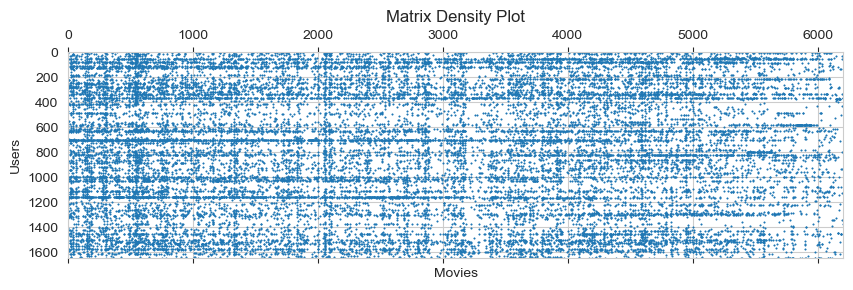

tags per user: <bound method NDFrame._add_numeric_operations.<locals>.sum of movieId  1       2       4       5       6       7       10      11      \
userId                                                                    
318       False   False   False   False   False   False   False   False   
320       False   False   False   False   False   False   False   False   
540       False   False   False   False   False   False   False   False   
693       False   False   False   False   False   False   False   False   
729       False   False   False   False   False   False   False   False   
...         ...     ...     ...     ...     ...     ...     ...     ...   
138200    False   False   False   False   False   False   False   False   
138207    False   False   False   False   False   False   False   False   
138209    False   False   False   False   False   False   False   False   
138211    False   False   False   False   False   False   False   False   
138280    False   False

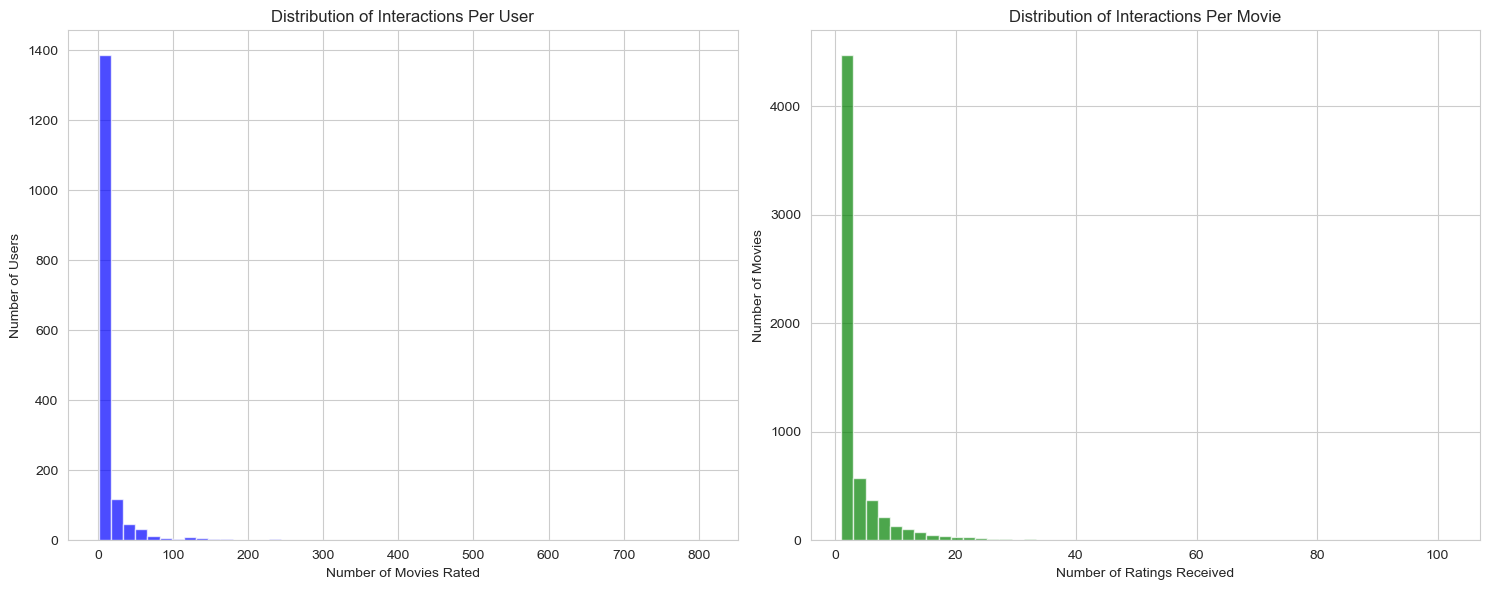

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'mat' is already your matrix

# 1. Calculate the Sparsity
total_values = mat.size
missing_values = mat.isna().sum().sum()
sparsity = missing_values / total_values
print(f"Sparsity of the matrix is: {sparsity * 100:.2f}%")


# 1. Matrix Density Plot
plt.figure(figsize=(10, 10))
plt.spy(mat, markersize=0.5)
plt.title('Matrix Density Plot')
plt.xlabel('Movies')
plt.ylabel('Users')
plt.show()


# Calculate the number of ratings per user and per movie
tags_per_user = mat.notna().sum  # Sum across row
tags_per_movie = mat.notna().sum(axis=1)    # Sum across column
print("tags per user: " + str(tags_per_user))
print("tags per movie: " + str(tags_per_movie))

# Calculate the number of interactions per user and per movie
interactions_per_user = mat.notna().sum(axis=1)  # Sum across columns for each user
interactions_per_movie = mat.notna().sum()       # Sum across rows for each movie

# Plotting

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histogram for Interactions per User
axes[0].hist(interactions_per_user, bins=50, color='blue', alpha=0.7)
axes[0].set_title('Distribution of Interactions Per User')
axes[0].set_xlabel('Number of Movies Rated')
axes[0].set_ylabel('Number of Users')

# Histogram for Interactions per Movie
axes[1].hist(interactions_per_movie, bins=50, color='green', alpha=0.7)
axes[1].set_title('Distribution of Interactions Per Movie')
axes[1].set_xlabel('Number of Ratings Received')
axes[1].set_ylabel('Number of Movies')

plt.tight_layout()
plt.show()




### Knn to impute missing values in the matrix 

We will return movieIds that correspond to the users' sentiment attitudes towards other movies and also similar users
    So for instance (movieId 4, negative) etc
    - This sentiment is based on how likely a user is going to feel about that movie - through their tagging behaviour
- E.g. if a user is consistently rating movies with positive sentiment, return the movieIds of SIMILAR users that are also rate movies with positive sentiment
- AKA finding users similar to target user based on their sentiment history 
- For similar users: the intersection between movies AND sentiment is taken (for example for a user to be similar, the user needs to have tagged the same movies with similar sentiments)
Steps:
1. Get similar users (using cosine similarity)
2. Recommendation
    - For target user, use similarity matrix and get similar users - should set a threshold for similarity.
    - Return movieIds and sentiment from the movies of similar users


**Calculate the similarity of users**
Based on movies they have tagged and the sentiments applied

Similarity score threshold = 0.8

Issue with mapping - user ids are not in a continuous mapping, this leads to out of bounds errors (need to fix this)

Method to fix:
- need to create a mapping between user id to continuous scale

**UserId mapping**
- Reset the index of the matrix 'mat' to get the original userId into a column. 
- Then create a mapping from these original userIds to a new continuous index (from 0 to N).
- Use this new index as the userId when performing computations and lookups in mat
- movieId here is still in its original form 

In [19]:
import pandas as pd

# Assuming 'mat' is your matrix
# Resetting the index will add a column 'userId' with the original values
mat = mat.reset_index()

# creating a dictionary with original userId and new continuous index
original_to_new_index = {old_id: new_id for new_id, old_id in enumerate(mat['userId'])}

# assign new continous index to the userId column 
mat['userId'] = mat['userId'].map(original_to_new_index)

# Now, set 'userId' as the index again
mat.set_index('userId', inplace=True)


If you want to get the original userId back then use the id lookup in original_to_new_index

##### 1) User-based method - KNN

1. Basic functions 
- cosine similarity
- dominant sentiment detection 

2. KNN computation
- Get the k nearest neighbours
- get recommendations based on dominant sentiment, or distributed sentiment 

3. Recommendations
- based on K, provides K different recommendations
- Format of recommendation: (movieId, sentiment)

**1) Basic Functions**

In [21]:
import numpy as np
from collections import defaultdict

def cosine_similarity(v1, v2):
    '''Cosine similarity function only computes similarity for NON-NAN values'''
    # Indices where both v1 and v2 are not NaN
    shared_idx = np.where(~np.isnan(v1) & ~np.isnan(v2))
    
    # If no shared indices, return 0
    if len(shared_idx[0]) == 0:
        return 0
    
    # Extract shared values
    v1_shared = v1[shared_idx]
    v2_shared = v2[shared_idx]

    # Compute the dot product and norms only on shared values
    dot_product = np.dot(v1_shared, v2_shared)
    norm_v1 = np.linalg.norm(v1_shared)
    norm_v2 = np.linalg.norm(v2_shared)

    # Prevent division by zero
    if norm_v1 == 0 or norm_v2 == 0:
        return 0

    return dot_product / (norm_v1 * norm_v2)


def get_sentiment_label(sentiment):
    if sentiment > 0.5:
        return "positive"
    elif sentiment < -0.5:
        return "negative"
    else:
        return "neutral"
    

def get_dominant_sentiment(user_sentiments):
    pos_count = sum(1 for s in user_sentiments if s > 0.5)
    neg_count = sum(1 for s in user_sentiments if s < -0.5)
    neutral_count = len(user_sentiments) - pos_count - neg_count

    if pos_count > neg_count and pos_count > neutral_count:
        return "positive"
    elif neg_count > pos_count and neg_count > neutral_count:
        return "negative"
    else:
        return "neutral"


**2) KNN**

In [22]:
def get_k_nearest_neighbors(target_user, matrix, k):
    similarities = {}
    
    for user in matrix.index:
        if user == target_user:
            continue
        common_movies = matrix.loc[target_user].dropna().index.intersection(matrix.loc[user].dropna().index)
        if len(common_movies) > 0:
            sim = cosine_similarity(matrix.loc[target_user][common_movies].values, matrix.loc[user][common_movies].values)
            similarities[user] = sim
            
    # Sort by similarity
    sorted_neighbors = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    return sorted_neighbors[:k]


**3) Recommendations**

If the target user has a neutral dominant sentiment (meaning they don't strongly lean positive or negative in their ratings), then the recommendation system will suggest a mix of movies: 3 positive, 3 neutral, and 3 negative (or as many as available in each category).

If the user has a clear dominant sentiment (either strongly positive or negative), then the system will recommend movies accordingly.

- Note: limit the number of recommendations to k

- Prediction: (movieId, sentiment)
    - Sentiment: 2 forms returned based on a similar user's sentiment towards a movie
        - 1) Clustered sentiment value (based on the semantic cluster previously)
        - 2) Raw sentiment value (without clustering)

In [23]:
user_indices = mat.index[mat.apply(lambda x: (x.count() == 1) and (x.dropna().iloc[0] > 0.5), axis=1)]

print(user_indices)


Index([], dtype='int64', name='userId')


In [ ]:
mat.loc[39].dropna()

In [ ]:
def get_distributed_recommendations(target_user, matrix, new_to_original_index, df_sent, k):
    # Get the sentiments for movies rated by the target user
    user_sentiments = matrix.loc[target_user].dropna()
    
    # Determine the dominant sentiment of the target user
    dominant_sentiment = get_dominant_sentiment(user_sentiments)
    
    # Get the k-most similar users
    similar_users = get_k_nearest_neighbors(target_user, matrix, k)
    sentiment_buckets = defaultdict(list)
    # For each similar user, gather movies they've rated

    for user, similarity in similar_users:
        # Map the user index to its original userId
        original_user_id = new_to_original_index[user]
        
        for movie, sentiment in matrix.loc[user].items():
            if not np.isnan(sentiment):
                
                # Filter df_sent to get rows for the current user and movie
                user_movie_df = df_sent[(df_sent['userId'] == original_user_id) & (df_sent['movieId'] == movie)]
                
                # If there are no sentiments for this user-movie pair, continue
                if user_movie_df.empty:
                    continue
                
                # Aggregate the scaled_sentiment_values. Here, I'm using mean, but you can adjust this
                movie_sentiment = user_movie_df['scaled_sentiment_value'].mean()
                
                sentiment_direction = get_dominant_sentiment([movie_sentiment])
                sentiment_buckets[sentiment_direction].append((movie, movie_sentiment))

    return sentiment_buckets[dominant_sentiment][:k] # returns movieId and sentiment value - scaled sentiment value from df_sent
    


In [ ]:
new_to_original_index = {v: k for k, v in original_to_new_index.items()} # this exists outside the function to ensure the new_to_original_index exists for mapping

target_user = 2 # Random target user index - this index is based on the new mapping, not the actual user ids - even if we pass this id into the function, we can store somewhere else the actual userId this recommendation is for 
recommendations = get_distributed_recommendations(target_user, mat, new_to_original_index, df_sent, 10)
recommendations

In [ ]:
new_to_original_index

#### Testing different K values
- Alongside cosine similarity value
- For each recommended movie for the test user, you'd like to know the cosine similarity between the test user and the users who recommended that movie.

#### Evaluation of KNN 

Linking the indexes back to the true userId and visualising recommendations - provides K recommendations
- Need to link these back to their true values because then we will use it for content-based and context-aware methods 

In [ ]:
len(new_to_original_index)

Testing:printing the target user average sentiment scores, tags, and tags of movies recommended

In [ ]:
df_sent

In [ ]:
tags

In [ ]:
### Storing the recommendations in a new dataframe
df_rec = df_sent[["userId"]].drop_duplicates().reset_index(drop=True)
df_rec['recommendations'] = None

df_rec

**Function that gets the recommendations and stores in df_rec**

- This takes 302 minutes to run 


- Speeds up computation (from 302 minutes -> to 20m)

In [ ]:
def generate_and_store_recommendations(df_rec, mat, new_to_original_index, df_sent, k=10):
    for idx, row in df_rec.iterrows():
        original_user_id = row['userId']
        
        # Map the original userId to the new continuous index
        target_user = original_to_new_index.get(original_user_id, None)
        
        # If the user exists in the matrix
        if target_user is not None:
            # Get recommendations
            recommendations = get_distributed_recommendations(target_user, mat, new_to_original_index, df_sent, k)
            
            # Store recommendations in df_rec under the original userId
            df_rec.at[idx, 'recommendations'] = recommendations

# Assume original_to_new_index exists and is the reverse mapping of new_to_original_index
original_to_new_index = {v: k for k, v in new_to_original_index.items()}

# Initialize recommendations column in df_rec
df_rec['recommendations'] = None

# Generate and store recommendations
generate_and_store_recommendations(df_rec, mat, new_to_original_index, df_sent)


In [ ]:
df_rec

In [ ]:
df_rec['recommendations'] = df_rec['recommendations'].apply(lambda x: [(int(a), round(b, 4)) for a, b in x])


The recommendations file output



In [0]:
df_rec

In [ ]:
tags[tags['userId'] == 96]

In [ ]:
df_comb

In [ ]:
df_comb_t = pd.merge(tags, df_comb, on='tag', how='left')
df_comb_t = df_comb_t[["movieId", "tag", "scaled_sentiment_value", "scaled_sentiment_value_cluster_avg"]]

df_comb_t[df_comb_t['movieId'] == 29].drop_duplicates(subset=['tag'])

Given this,

ideally we would like to recommend "surreal", "dreamlike", "atmospheric", "child" to this user

Another example for thesis: 
- If we don't use the cluster sentiment average to recommend -> then we would miss the "dreamlike" example 


### Generating an initial set of tags from the movieId, sentiment recommendation

- This will be stored in a separate column in the df_rec dataframe

Process:
- Access the movieId, tags from "df_comb_t" dataframe and then find the similarity on the scaled_sentiment_value_avg column
    - similarity calculated by comparing the difference of atomic values (single values) ==> Euclidean distance

Finding a good similarity range 
- Plotting the distribution of the data
    - Sentiment value is between -1 and 1 
        - Similar values should be within the SAME sentiment range 
        For example: if a sentiment is -0.2 - this is neutral so the similar one should be neutral as well 

        Ranges:
        - Negative: [-1, -0.5)
        - Neutral: [-0.5, 0.5]
        - Positive: (0.5, 1]

New column in the dataframe will have this structure: 
[ [movieId, [tags,......]], ....],   [movieId, [tags,......]], ....] ] 

In [ ]:
df_comb_t


In [ ]:
# Looping through df_rec and getting the similar tags for each user into a new column and put them in the same dataframe

# note: tags for each movieId in the tags_movies column is distinct 
# Looping through df_rec and getting the similar tags for each user into a new column and put them in the same dataframe

# Define sentiment category function
def determine_sentiment_category(sentiment_value):
    if -1 <= sentiment_value < -0.5:
        return 'Negative'
    elif -0.5 <= sentiment_value <= 0.5:
        return 'Neutral'
    else:
        return 'Positive'

# Extract tags function
def get_tags_for_movie(movieId, sentiment_value):
    sentiment_category = determine_sentiment_category(sentiment_value)
    
    # Filter rows with matching movieId and sentiment category
    tags = df_comb_t[(df_comb_t['movieId'] == movieId) & 
                     (df_comb_t['scaled_sentiment_value_cluster_avg'].apply(determine_sentiment_category) == sentiment_category)]['tag'].tolist()
    
    # Convert tags list to set and back to list to ensure distinct tags
    distinct_tags = list(set(tags))
    
    return (movieId, distinct_tags)

# Apply function on recommendations column
df_rec['tags_movies'] = df_rec['recommendations'].apply(lambda recs: [get_tags_for_movie(movieId, sentiment_value) for movieId, sentiment_value in recs])


Recommendations file output


In [ ]:
df_rec.to_json('../dataset/df_rec.json', orient='split')

df_rec


**Removing users that have <5 tags**

In [ ]:
df_rec = pd.read_json('../dataset/df_rec.json', orient='split')

In [ ]:
df_rec

In [ ]:
# Count the number of tags for each userId
tag_counts = tags.groupby('userId')['tag'].count().reset_index()
tag_counts.columns = ['userId', 'tag_count']

users_sparse = tag_counts[tag_counts['tag_count'] <= 5]


user_ids_to_remove = users_sparse['userId'].tolist()

no_rec_and_5_tags = df_rec[(df_rec['userId'].isin(user_ids_to_remove)) & (df_rec['recommendations'].str.len() == 0)]

user_ids_to_remove = no_rec_and_5_tags['userId'].tolist()

df_rec = df_rec[~df_rec['userId'].isin(user_ids_to_remove)]



In [ ]:
df_rec

In [ ]:
# store df_rec in file 
import json 
df_rec.to_json('../dataset/df_rec.json', orient='split', index=False)

In [ ]:
tag_clusters = df_comb[["tag", "cluster"]]

tag_clusters.to_csv("../dataset/tag_clusters.csv", index=False)

Finding how many tags the sparse users have tagged


In [ ]:
# Count the number of tags for each userId
tag_counts = tags.groupby('userId')['tag'].count().reset_index()
tag_counts.columns = ['userId', 'tag_count']


In [ ]:
tag_counts

### Visualisations of tag distribution

In [ ]:
import matplotlib.pyplot as plt

tag_distribution = tag_counts['tag_count'].value_counts().sort_index()

plt.figure(figsize=(10,5))
plt.hist(tag_counts['tag_count'], bins=50, range=(1, 50), edgecolor='black', alpha=0.7)
plt.title('Distribution of Number of Tags per User')
plt.xlabel('Number of Tags')
plt.ylabel('Number of Users')
plt.grid(axis='y')
plt.xlim(1, 50)  # set x-axis limits
plt.show()


### Evaluation


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data from the user's description


# Creating a DataFrame
df = tags

# Calculating average number of tags per user
avg_tags_per_user = df.groupby('userId')['tag'].count().mean()

# For calculating the average number of movies rated per user,
# we need to count unique movieIds per user and then find the average
avg_movies_rated_per_user = df.groupby('userId')['movieId'].nunique().mean()

# Preparing data for the graph
user_counts = df.groupby('userId').agg({'tag': 'count', 'movieId': lambda x: x.nunique()}).reset_index()
user_counts.columns = ['userId', 'num_tags', 'num_movies']

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(user_counts['num_movies'], user_counts['num_tags'], color='blue')
plt.title('Number of Tags vs Number of Movies Rated per User')
plt.xlabel('Number of Movies Rated')
plt.ylabel('Number of Tags')
plt.grid(True)
plt.show()

avg_tags_per_user, avg_movies_rated_per_user


In [ ]:
# Counting the number of tags per user
tags_count_per_user = df.groupby('userId')['tag'].count()

# Counting the number of users with less than 10 tags
users_less_than_10_tags = tags_count_per_user[tags_count_per_user < 10].count()

users_less_than_10_tags

In [ ]:
# Recalculating to get distinct count of tags and distinct count of userIds for each tag count
tag_count_with_user_count = df.groupby('userId')['tag'].nunique().reset_index()
tag_count_with_user_count = tag_count_with_user_count.groupby('tag').count()
tag_count_with_user_count = tag_count_with_user_count[tag_count_with_user_count.index < 10]
tag_count_with_user_count.columns = ['user_count']
tag_count_with_user_count.reset_index(inplace=True)
tag_count_with_user_count.columns = ['tag_count', 'user_count']
tag_count_with_user_count


In [ ]:
tags

# Dataset Visualization

In [1]:
import pandas as pd

In [2]:
tags = pd.read_csv("../dataset/sentiment_df.csv")
tags['tag'] = tags['tag'].astype('str')
df_comb = pd.read_csv("../dataset/clustercheck.csv")

In [3]:
# df_comb.to_csv("../dataset/clustercheck.csv")
avg_sentiment_by_cluster = df_comb.groupby('cluster')['scaled_sentiment_value'].mean().reset_index()
df_comb = pd.merge(df_comb, avg_sentiment_by_cluster, on='cluster', suffixes=('', '_cluster_avg'))


In [4]:
df_comb = df_comb.drop(columns=['glove_vec'])

df_mat = tags.merge(df_comb, on=['tag'], how='inner')
# df_mat

# df_sent = df_mat # take copy for later on 


# Convert the 'scaled_sentiment_value_avg' column to float
df_mat['scaled_sentiment_value_cluster_avg'] = df_mat['scaled_sentiment_value_cluster_avg'].astype('float')

# Keep only relevant columns
df_mat = df_mat[["userId", "movieId", "scaled_sentiment_value_cluster_avg"]]

# Check for duplicates and print them
duplicates = df_mat[df_mat.duplicated(subset=['userId', 'movieId'], keep=False)]


# Group by 'userId' and 'movieId' to get the average 'scaled_sentiment_value_avg'
df_mat = df_mat.groupby(['userId', 'movieId'])['scaled_sentiment_value_cluster_avg'].mean().reset_index()

# Create the pivot table
mat = pd.pivot_table(df_mat, values='scaled_sentiment_value_cluster_avg', index=['userId'], columns=['movieId'])



In [5]:

# tags.drop(columns=['Unnamed: 0','Unnamed: 0.1'], inplace=True)
tags

,Unnamed: 0,Unnamed: 0.1,userId,movieId,tag,timestamp,un-lemmatised
0,7,266,318,260,s,2015-02-20 22:42:49,NaN
1,8,267,318,115149,action,2015-02-21 15:58:30,action
2,15,274,320,2762,twist,2006-04-25 11:33:52,twist
3,16,275,320,2959,twist,2006-04-25 11:30:58,twist
4,17,276,320,3996,overrate,2006-04-25 11:32:28,overrated
...,...,...,...,...,...,...,...
50186,109306,390955,138280,116797,history,2015-01-30 23:07:25,history
50187,109307,390956,138280,116797,informatics,2015-01-30 23:07:35,informatics
50188,109308,390957,138280,116797,mathematics,2015-01-30 23:07:17,mathematics
50189,109310,390959,138280,117871,image,2015-01-30 23:09:16,image


In [6]:
df_mat

,userId,movieId,scaled_sentiment_value_cluster_avg
0,318,260,0.203666
1,318,115149,0.174136
2,320,2762,0.121250
3,320,2959,0.121250
4,320,3996,0.089884
...,...,...,...
23934,138280,115170,0.179037
23935,138280,115210,0.239520
23936,138280,116397,0.105541
23937,138280,116797,0.154063


In [7]:
# creating matrix again -> proper display
mat = pd.pivot_table(df_mat, values='scaled_sentiment_value_cluster_avg', index=['userId'], columns=['movieId'])
# mat.loc[96][106696] # uses the scaled_sentiment_value_avg as the sentiment value

In [8]:
tag_counts = tags.groupby('userId')['tag'].count().reset_index()
tag_counts.columns = ['userId', 'tag_count']
tag_counts

,userId,tag_count
0,318,2
1,320,5
2,540,4
3,693,36
4,729,1
...,...,...
1654,138200,32
1655,138207,6
1656,138209,19
1657,138211,1


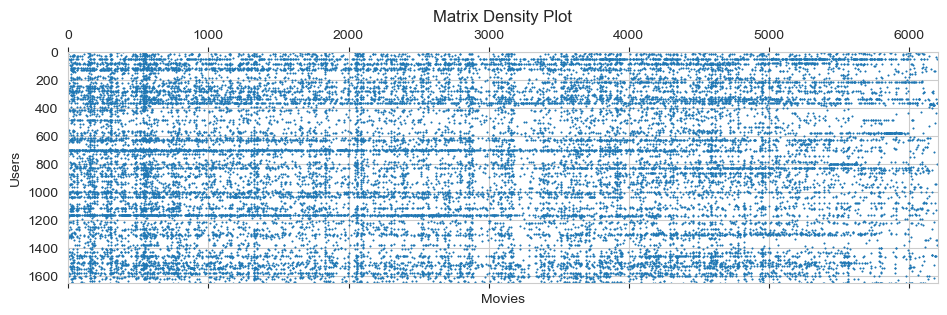

In [10]:
import matplotlib.pyplot as plt

# 1. Matrix Density Plot
plt.figure(figsize=(25, 3))
plt.spy(mat, markersize=0.5)
plt.title('Matrix Density Plot')
plt.xlabel('Movies')
plt.ylabel('Users')
plt.show()

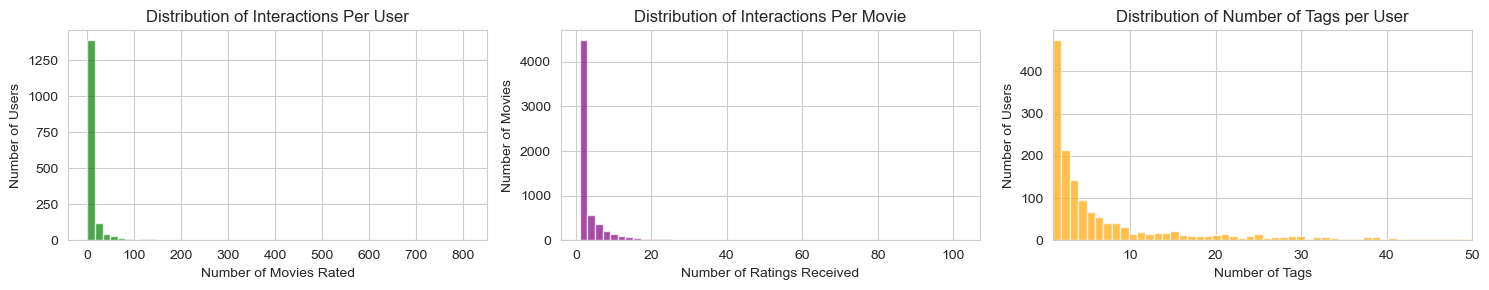

In [22]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create a 1x4 grid layout
fig, axes = plt.subplots(1, 3, figsize=(15, 3))

# Histogram for Interactions per User
axes[0].hist(interactions_per_user, bins=50, color='green', alpha=0.7)
axes[0].set_title('Distribution of Interactions Per User')
axes[0].set_xlabel('Number of Movies Rated')
axes[0].set_ylabel('Number of Users')

# Histogram for Interactions per Movie
axes[1].hist(interactions_per_movie, bins=50, color='purple', alpha=0.7)
axes[1].set_title('Distribution of Interactions Per Movie')
axes[1].set_xlabel('Number of Ratings Received')
axes[1].set_ylabel('Number of Movies')

# Histogram for Number of Tags per User
axes[2].hist(tag_counts['tag_count'], bins=50, range=(1, 50), color='orange', alpha=0.7)
axes[2].set_title('Distribution of Number of Tags per User')
axes[2].set_xlabel('Number of Tags')
axes[2].set_ylabel('Number of Users')
# axes[2].grid(axis='y')
axes[2].set_xlim(1, 50)  # set x-axis limits

plt.tight_layout()
plt.show()
